# Importing Stuff

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

# Setting constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

# Creating tf.dataset

In [3]:
tomato_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\College Stuff\TY\ML\MP\Dataset\Tomato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 18160 files belonging to 10 classes.


In [4]:
class_names = tomato_dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Mosaic_virus',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Two_spotted_spider_mite',
 'Yellow_Leaf_Curl_Virus']

In [5]:
len(tomato_dataset)

568

In [6]:
for image_batch, labels_batch in tomato_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[9 1 4 9 2 6 9 2 4 6 9 0 3 5 7 2 3 3 7 9 8 8 2 6 9 1 3 3 9 0 6 9]


# Dataset Visualization

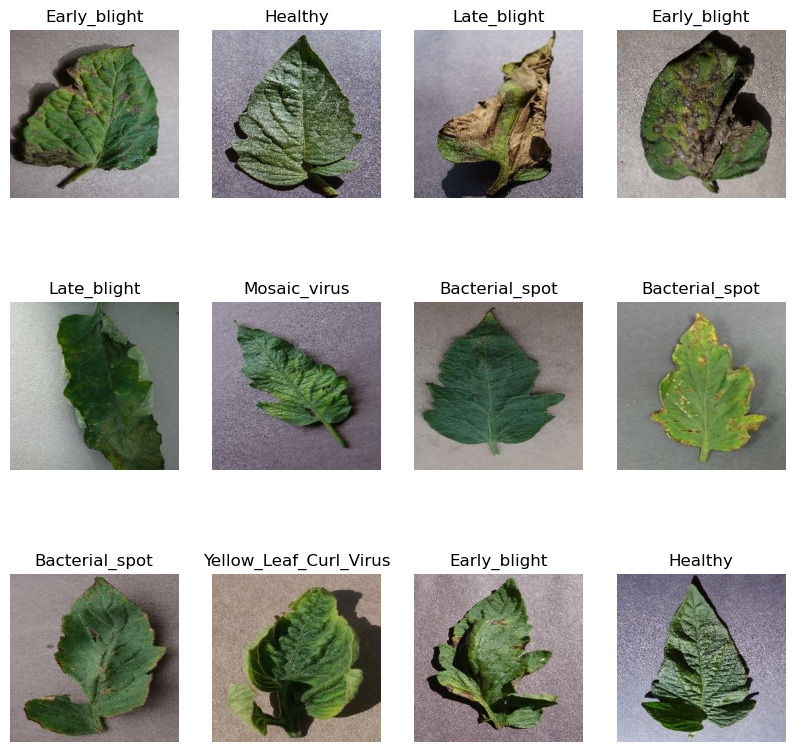

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in tomato_dataset.take(5):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Train-Test Split

In [8]:
len(tomato_dataset)

568

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
tomato_train, tomato_val, tomato_test = get_dataset_partitions_tf(tomato_dataset)

In [11]:
len(tomato_dataset), len(tomato_train), len(tomato_val), len(tomato_test)

(568, 454, 56, 58)

### Cache Suffle Prefetch

In [12]:
train_ds = tomato_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = tomato_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tomato_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing, Rescaling

In [13]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
tomato_train = tomato_train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [16]:
tomato_train = tomato_train.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model: CNN

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the model

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
class TrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') > 0.99:
            print('The model has reached the accuracy desired (0.99), stop the training!')
            self.model.stop_training = True

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks = TrainingCallback()
)

Epoch 1/30
106/454 [======>.......................] - ETA: 12:02 - loss: 1.8536 - accuracy: 0.3547

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(22), acc, label='Training Accuracy')
plt.plot(range(22), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(22), loss, label='Training Loss')
plt.plot(range(22), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save("tomato_cnn.h5")